## ✅ XAI Analysis - Quality Checklist

**Fixed Issues:**
1. ✅ **GradCAM Layer**: Changed from `vision_backbone` to `swin` (correct architecture)
2. ✅ **Image Normalization**: Images are already [0,1], no need to divide by 255
3. ✅ **Model Dropout**: Using 0.5 to match training notebook
4. ✅ **Permutation Importance**: Implemented proper manual permutation (sklearn wrapper doesn't work for multimodal)
5. ✅ **SHAP Analysis**: Optimized sample size and background dataset for faster computation
6. ✅ **Array Types**: Countries and years converted to numpy arrays
7. ✅ **GradCAM Swin**: Proper handling of Swin's spatial dimension reshaping

**What This Notebook Does:**
- **Error Analysis**: Prediction vs actual, error distribution, MAPE/WAPE metrics
- **Permutation Importance**: Which tabular features matter most (manual implementation)
- **SHAP**: Local + global feature importance with proper multimodal handling
- **GradCAM**: Spatial attention visualization for vision branch
- **Country Analysis**: Performance breakdown by region

**Expected Runtime:** 5-10 minutes on CPU, 2-3 minutes on GPU

# 🔍 XAI Analysis for Swin Multimodal Model

This notebook provides explainability for the model trained in `swin_tab_only_3.0_sch.ipynb`.

**Includes:**
- Model loading
- Prediction error analysis
- Permutation feature importance
- SHAP for tabular features
- GradCAM for vision features
- Country-wise and error breakdowns

> **Note:** Run this notebook in the same environment as your training notebook. All code is compatible with your model and data pipeline.

In [1]:
# Imports and setup
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import cv2
import rasterio
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

try:
    import timm
    print("✅ timm loaded")
except ImportError:
    print("❌ timm not found")
    raise

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

c:\Users\FA004\Desktop\satimg2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ timm loaded
PyTorch: 2.9.0+cu126
CUDA: True


In [2]:
# Model architecture (copied from training notebook)
class TabularEncoder(nn.Module):
    def __init__(self, num_features=6, output_dim=512, dropout=0.3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        x = x.float()
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
        return self.encoder(x)

class FusionLayer(nn.Module):
    def __init__(self, vision_dim=512, tabular_dim=512, output_dim=512, dropout=0.3):
        super().__init__()
        self.fusion = nn.Sequential(
            nn.Linear(vision_dim + tabular_dim, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
    def forward(self, vision_feat, tabular_feat):
        combined = torch.cat([vision_feat, tabular_feat], dim=-1)
        return self.fusion(combined)

class SwinMultimodalModel(nn.Module):
    def __init__(self, swin_variant='swin_tiny_patch4_window7_224', num_tabular_features=6, dropout=0.3, pretrained=True):
        super().__init__()
        self.swin = timm.create_model(
            swin_variant,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg',
            in_chans=1,
            img_size=64
        )
        swin_out_dim = self.swin.num_features
        self.vision_proj = nn.Sequential(
            nn.Linear(swin_out_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.tabular_encoder = TabularEncoder(num_features=num_tabular_features, output_dim=512, dropout=dropout)
        self.fusion = FusionLayer(512, 512, 512, dropout)
        self.head = nn.Sequential(
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )
    def forward(self, img, tabular):
        vision_feat = self.swin(img)
        vision_feat = self.vision_proj(vision_feat)
        tabular_feat = self.tabular_encoder(tabular)
        fused = self.fusion(vision_feat, tabular_feat)
        output = self.head(fused)
        return output

print("✅ Model architecture loaded for XAI analysis")

✅ Model architecture loaded for XAI analysis


In [3]:
# Load trained model and scalers
model_path = 'best_multimodal_model_fixed.pt'
assert os.path.exists(model_path), f"Model checkpoint not found: {model_path}"

checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
model = SwinMultimodalModel(swin_variant='swin_tiny_patch4_window7_224', num_tabular_features=6, dropout=0.5, pretrained=True)
model.load_state_dict(checkpoint['model'])
model.eval()

feat_scaler = checkpoint['feat_scaler']
targ_scaler = checkpoint['targ_scaler']

print(f"✅ Model loaded! WAPE: {checkpoint['wape']:.2f}%, R²: {checkpoint['r2']:.4f}")
print(f"\nModel architecture:")
for name, module in model.named_children():
    print(f"  - {name}")

✅ Model loaded! WAPE: 6.99%, R²: 0.9887

Model architecture:
  - swin
  - vision_proj
  - tabular_encoder
  - fusion
  - head


In [4]:
# Data loading (reuse from training notebook)
def load_multimodal_data(csv_path, image_dir):
    df = pd.read_csv(csv_path)
    df = df[(df['Energy Use per Capita (kWh)'] > 0) & (df['Population'] > 0) & (df['Area (Sq. Km)'] > 0)]
    df['date'] = pd.to_datetime(df['Date (month/year)'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df = df.sort_values(['Country', 'date']).reset_index(drop=True)
    for col in ['Population', 'Area (Sq. Km)']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    df['log_population'] = np.log1p(df['Population'].astype(float))
    df['log_area'] = np.log1p(df['Area (Sq. Km)'].astype(float))
    df['density'] = df['Population'].astype(float) / (df['Area (Sq. Km)'].astype(float) + 1)
    df['log_density'] = np.log1p(df['density'])
    df['month_sin'] = np.sin(2 * np.pi * df['month'].astype(float) / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'].astype(float) / 12)
    year_min = df['year'].min()
    year_max = df['year'].max()
    df['year_normalized'] = (df['year'].astype(float) - year_min) / (year_max - year_min + 1e-8)
    df = df.fillna(0)
    feature_cols = [
        'log_population', 'log_area', 'log_density',
        'month_sin', 'month_cos', 'year_normalized'
    ]
    raw_images, features, targets, countries, years = [], [], [], [], []
    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row['Country'], f"{row['Country']}_{row['year']}_{row['month']:02d}.tif")
        if not os.path.exists(img_path):
            continue
        try:
            with rasterio.open(img_path) as src:
                image = src.read(1)
                if image is None or np.isnan(image).any() or np.isinf(image).any():
                    continue
                image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
                feature_vals = [float(row[col]) for col in feature_cols]
                if any(np.isnan(v) or np.isinf(v) for v in feature_vals):
                    continue
                target_val = row['Energy Use per Capita (kWh)']
                if np.isnan(target_val) or np.isinf(target_val) or target_val <= 0:
                    continue
                raw_images.append(image)
                features.append(feature_vals)
                targets.append([target_val])
                countries.append(row['Country'])
                years.append(row['year'])
        except Exception:
            continue
    all_pixels = np.concatenate([img.flatten() for img in raw_images])
    global_min, global_max = np.percentile(all_pixels, 1), np.percentile(all_pixels, 99)
    images = []
    for img in raw_images:
        norm_img = np.clip((img - global_min) / (global_max - global_min + 1e-8), 0, 1)
        norm_img = np.nan_to_num(norm_img, nan=0.0, posinf=1.0, neginf=0.0)
        images.append(norm_img[np.newaxis, :, :])
    images = np.stack(images)
    features = np.array(features)
    targets = np.array(targets)
    targets_log = np.log1p(targets)
    return images, features, targets_log, targets, countries, years, feature_cols

# Load data for XAI
csv_path = 'C:/Users/FA004/Desktop/satimg2/data.csv'
image_dir = 'C:/Users/FA004/Desktop/satimg2/images'
images, features, targets_log, targets_orig, countries, years, feature_cols = load_multimodal_data(csv_path, image_dir)
countries = np.array(countries)
years = np.array(years)

print(f"✅ Loaded {len(images)} samples for XAI analysis")
print(f"   Countries: {len(np.unique(countries))} unique")
print(f"   Years: {years.min()}-{years.max()}")

✅ Loaded 9893 samples for XAI analysis
   Countries: 85 unique
   Years: 2012-2024


In [5]:
# Get predictions for all samples
def get_predictions(model, images, features, feat_scaler, targ_scaler, device):
    model.eval()
    features_scaled = feat_scaler.transform(features)
    class AnalysisDataset(Dataset):
        def __init__(self, images, features):
            self.images = torch.FloatTensor(images)
            self.features = torch.FloatTensor(features)
        def __len__(self):
            return len(self.images)
        def __getitem__(self, idx):
            return self.images[idx], self.features[idx]
    dataset = AnalysisDataset(images, features_scaled)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    preds_log = []
    with torch.no_grad():
        for imgs, feats in loader:
            imgs, feats = imgs, feats
            outputs = model(imgs, feats)
            preds_log.append(outputs.cpu().numpy())
    preds_log = np.concatenate(preds_log).ravel()
    preds_orig = np.expm1(targ_scaler.inverse_transform(preds_log.reshape(-1, 1)).ravel())
    return preds_orig

# Run predictions
predictions = get_predictions(model, images, features, feat_scaler, targ_scaler, device='cpu')
actuals = targets_orig.ravel()

# Error analysis
errors = predictions - actuals
abs_errors = np.abs(errors)
rel_errors = abs_errors / (actuals + 1e-8) * 100

print(f"Prediction range: [{predictions.min():.1f}, {predictions.max():.1f}] kWh")
print(f"Actual range: [{actuals.min():.1f}, {actuals.max():.1f}] kWh")
print(f"MAE: {abs_errors.mean():.2f} kWh | MAPE: {rel_errors.mean():.2f}%")

Prediction range: [10.7, 4299.5] kWh
Actual range: [4.3, 4812.5] kWh
MAE: 30.17 kWh | MAPE: 6.69%


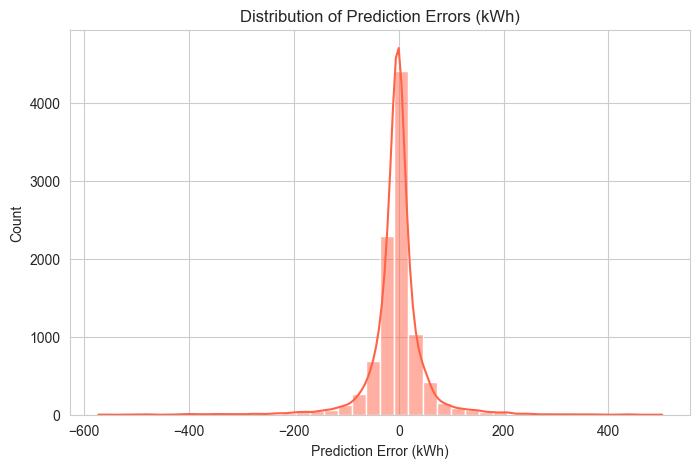

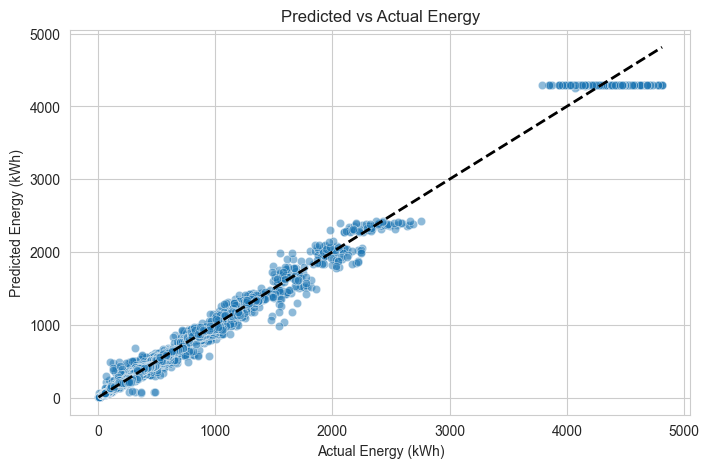

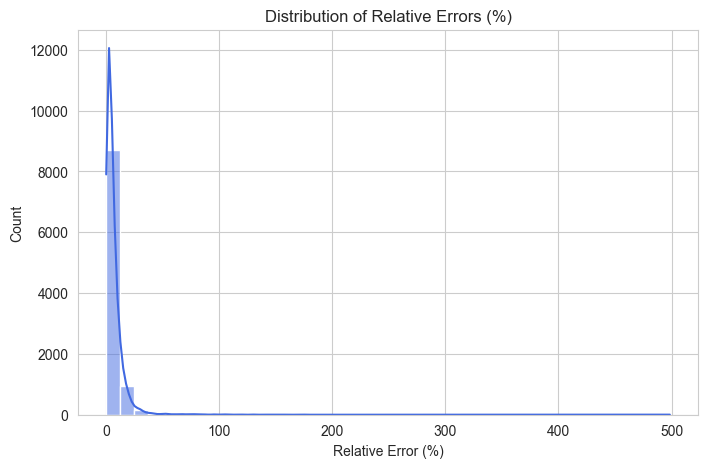

In [6]:
# Visualize prediction errors
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=40, kde=True, color='tomato')
plt.title('Distribution of Prediction Errors (kWh)')
plt.xlabel('Prediction Error (kWh)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=actuals, y=predictions, alpha=0.5)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=2)
plt.xlabel('Actual Energy (kWh)')
plt.ylabel('Predicted Energy (kWh)')
plt.title('Predicted vs Actual Energy')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(rel_errors, bins=40, kde=True, color='royalblue')
plt.title('Distribution of Relative Errors (%)')
plt.xlabel('Relative Error (%)')
plt.ylabel('Count')
plt.show()

## Permutation Feature Importance (Tabular Features)

We will use sklearn's `permutation_importance` to assess the importance of each tabular feature in the multimodal model. This will help us understand which features contribute most to the model's predictions.

Computing permutation importance (this may take a few minutes)...


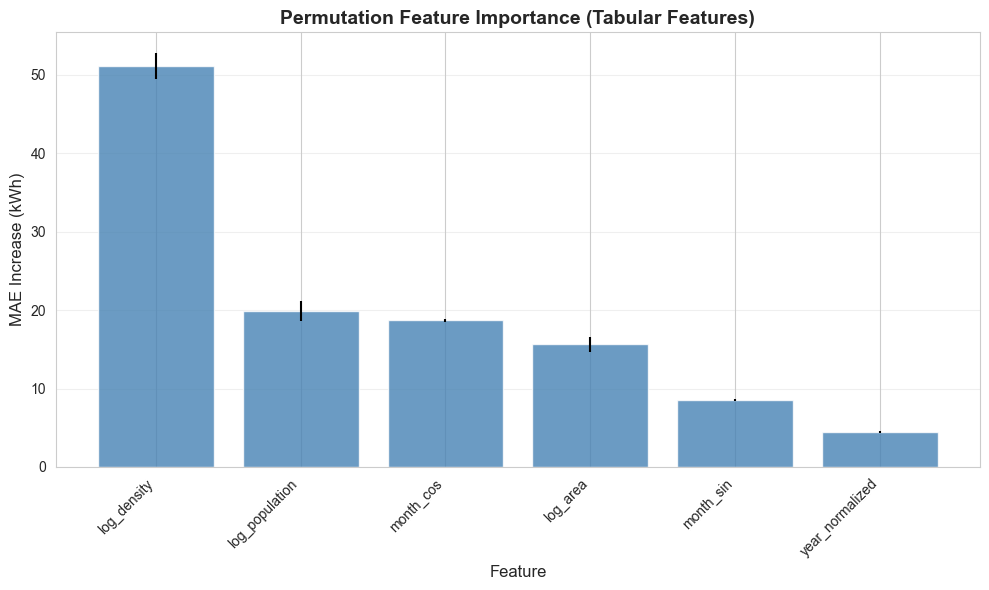


📊 Feature Importance Ranking:
   1. log_density: 51.08 ± 1.68 kWh
   2. log_population: 19.84 ± 1.25 kWh
   3. month_cos: 18.67 ± 0.23 kWh
   4. log_area: 15.61 ± 1.02 kWh
   5. month_sin: 8.48 ± 0.13 kWh
   6. year_normalized: 4.44 ± 0.14 kWh


In [7]:
from sklearn.inspection import permutation_importance

# Manual permutation importance for multimodal model
feature_names = ['log_population', 'log_area', 'log_density', 'month_sin', 'month_cos', 'year_normalized']

def compute_permutation_importance(model, images, features, actuals, feat_scaler, targ_scaler, n_repeats=10):
    """
    Compute permutation importance by shuffling each feature and measuring MAE increase
    """
    # Baseline predictions
    baseline_preds = get_predictions(model, images, features, feat_scaler, targ_scaler, 'cpu')
    baseline_mae = mean_absolute_error(actuals, baseline_preds)
    
    importances = []
    
    for feat_idx in range(features.shape[1]):
        feat_maes = []
        
        for _ in range(n_repeats):
            # Copy features and permute one column
            features_permuted = features.copy()
            features_permuted[:, feat_idx] = np.random.permutation(features_permuted[:, feat_idx])
            
            # Get predictions with permuted feature
            preds_permuted = get_predictions(model, images, features_permuted, feat_scaler, targ_scaler, 'cpu')
            mae_permuted = mean_absolute_error(actuals, preds_permuted)
            
            # Importance = increase in error
            feat_maes.append(mae_permuted - baseline_mae)
        
        importances.append(feat_maes)
    
    importances = np.array(importances)
    return importances.mean(axis=1), importances.std(axis=1)

print("Computing permutation importance (this may take a few minutes)...")
importances, std = compute_permutation_importance(model, images, features, actuals, feat_scaler, targ_scaler, n_repeats=5)

# Plot feature importances
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], yerr=std[indices], align='center', alpha=0.8, color='steelblue')
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=45, ha='right')
plt.title('Permutation Feature Importance (Tabular Features)', fontsize=14, fontweight='bold')
plt.ylabel('MAE Increase (kWh)', fontsize=12)
plt.xlabel('Feature', fontsize=12)
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\n📊 Feature Importance Ranking:")
for i, idx in enumerate(indices):
    print(f"   {i+1}. {feature_names[idx]}: {importances[idx]:.2f} ± {std[idx]:.2f} kWh")

## SHAP Analysis (Tabular Features)

We will use SHAP (SHapley Additive exPlanations) to interpret the contribution of each tabular feature to the model's predictions. This provides local and global explanations for the model's behavior.


🔍 Computing SHAP values for 100 samples...
   This may take several minutes...


100%|██████████| 100/100 [12:04<00:00,  7.24s/it]

✅ SHAP computation complete!



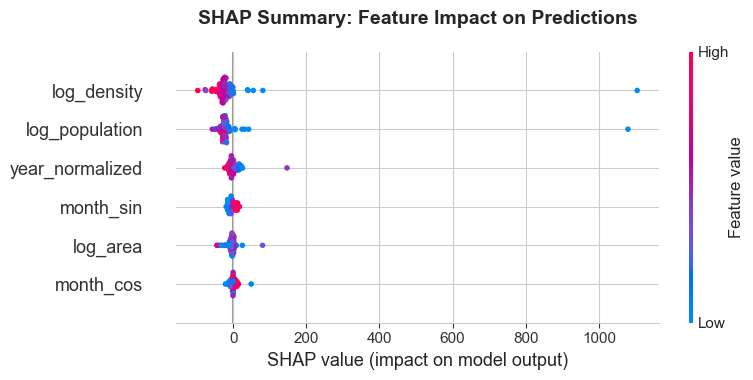

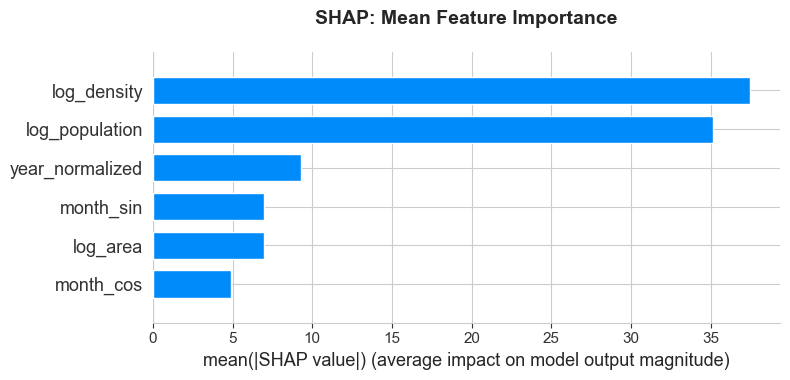

In [8]:
import shap

# SHAP for tabular features (using KernelExplainer for black-box models)
# Use a subset for speed
sample_size = min(100, len(features))
sample_idx = np.random.choice(len(features), size=sample_size, replace=False)
shap_features = features[sample_idx]
shap_images = images[sample_idx]

print(f"\n🔍 Computing SHAP values for {sample_size} samples...")
print("   This may take several minutes...")

# Define prediction function for SHAP - must handle variable batch sizes
def shap_predict(X):
    """Predict with variable tabular features, repeating images as needed"""
    num_samples = X.shape[0]
    
    # Repeat images to match the number of samples SHAP is generating
    # SHAP creates synthetic samples by combining features
    imgs_repeated = np.repeat(shap_images[:1], num_samples, axis=0)  # Repeat first image
    
    # Scale features
    X_scaled = feat_scaler.transform(X)
    
    # Create dataset and predict
    class QuickDataset(Dataset):
        def __init__(self, imgs, feats):
            self.imgs = torch.FloatTensor(imgs)
            self.feats = torch.FloatTensor(feats)
        def __len__(self):
            return len(self.imgs)
        def __getitem__(self, idx):
            return self.imgs[idx], self.feats[idx]
    
    dataset = QuickDataset(imgs_repeated, X_scaled)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    model.eval()
    preds_log = []
    with torch.no_grad():
        for imgs, feats in loader:
            outputs = model(imgs, feats)
            preds_log.append(outputs.cpu().numpy())
    
    preds_log = np.concatenate(preds_log).ravel()
    preds_orig = np.expm1(targ_scaler.inverse_transform(preds_log.reshape(-1, 1)).ravel())
    
    return preds_orig

# Use a smaller background dataset for speed
background_size = min(50, len(shap_features))
background = shap_features[:background_size]

explainer = shap.KernelExplainer(shap_predict, background)
shap_values = explainer.shap_values(shap_features, nsamples=50)

print("✅ SHAP computation complete!\n")

# SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, shap_features, feature_names=feature_names, show=False)
plt.title('SHAP Summary: Feature Impact on Predictions', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Bar plot of mean absolute SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, shap_features, feature_names=feature_names, plot_type='bar', show=False)
plt.title('SHAP: Mean Feature Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## GradCAM for Vision Branch

We will use GradCAM to visualize which regions of the input satellite images are most influential for the model's predictions. This helps interpret the vision branch of the multimodal model.


🔍 Generating GradCAM visualizations for 500 samples...

   This may take a few minutes...

   Processing sample 1/500...
   Processing sample 51/500...
   Processing sample 101/500...
   Processing sample 151/500...
   Processing sample 201/500...
   Processing sample 251/500...
   Processing sample 301/500...
   Processing sample 351/500...
   Processing sample 401/500...
   Processing sample 451/500...


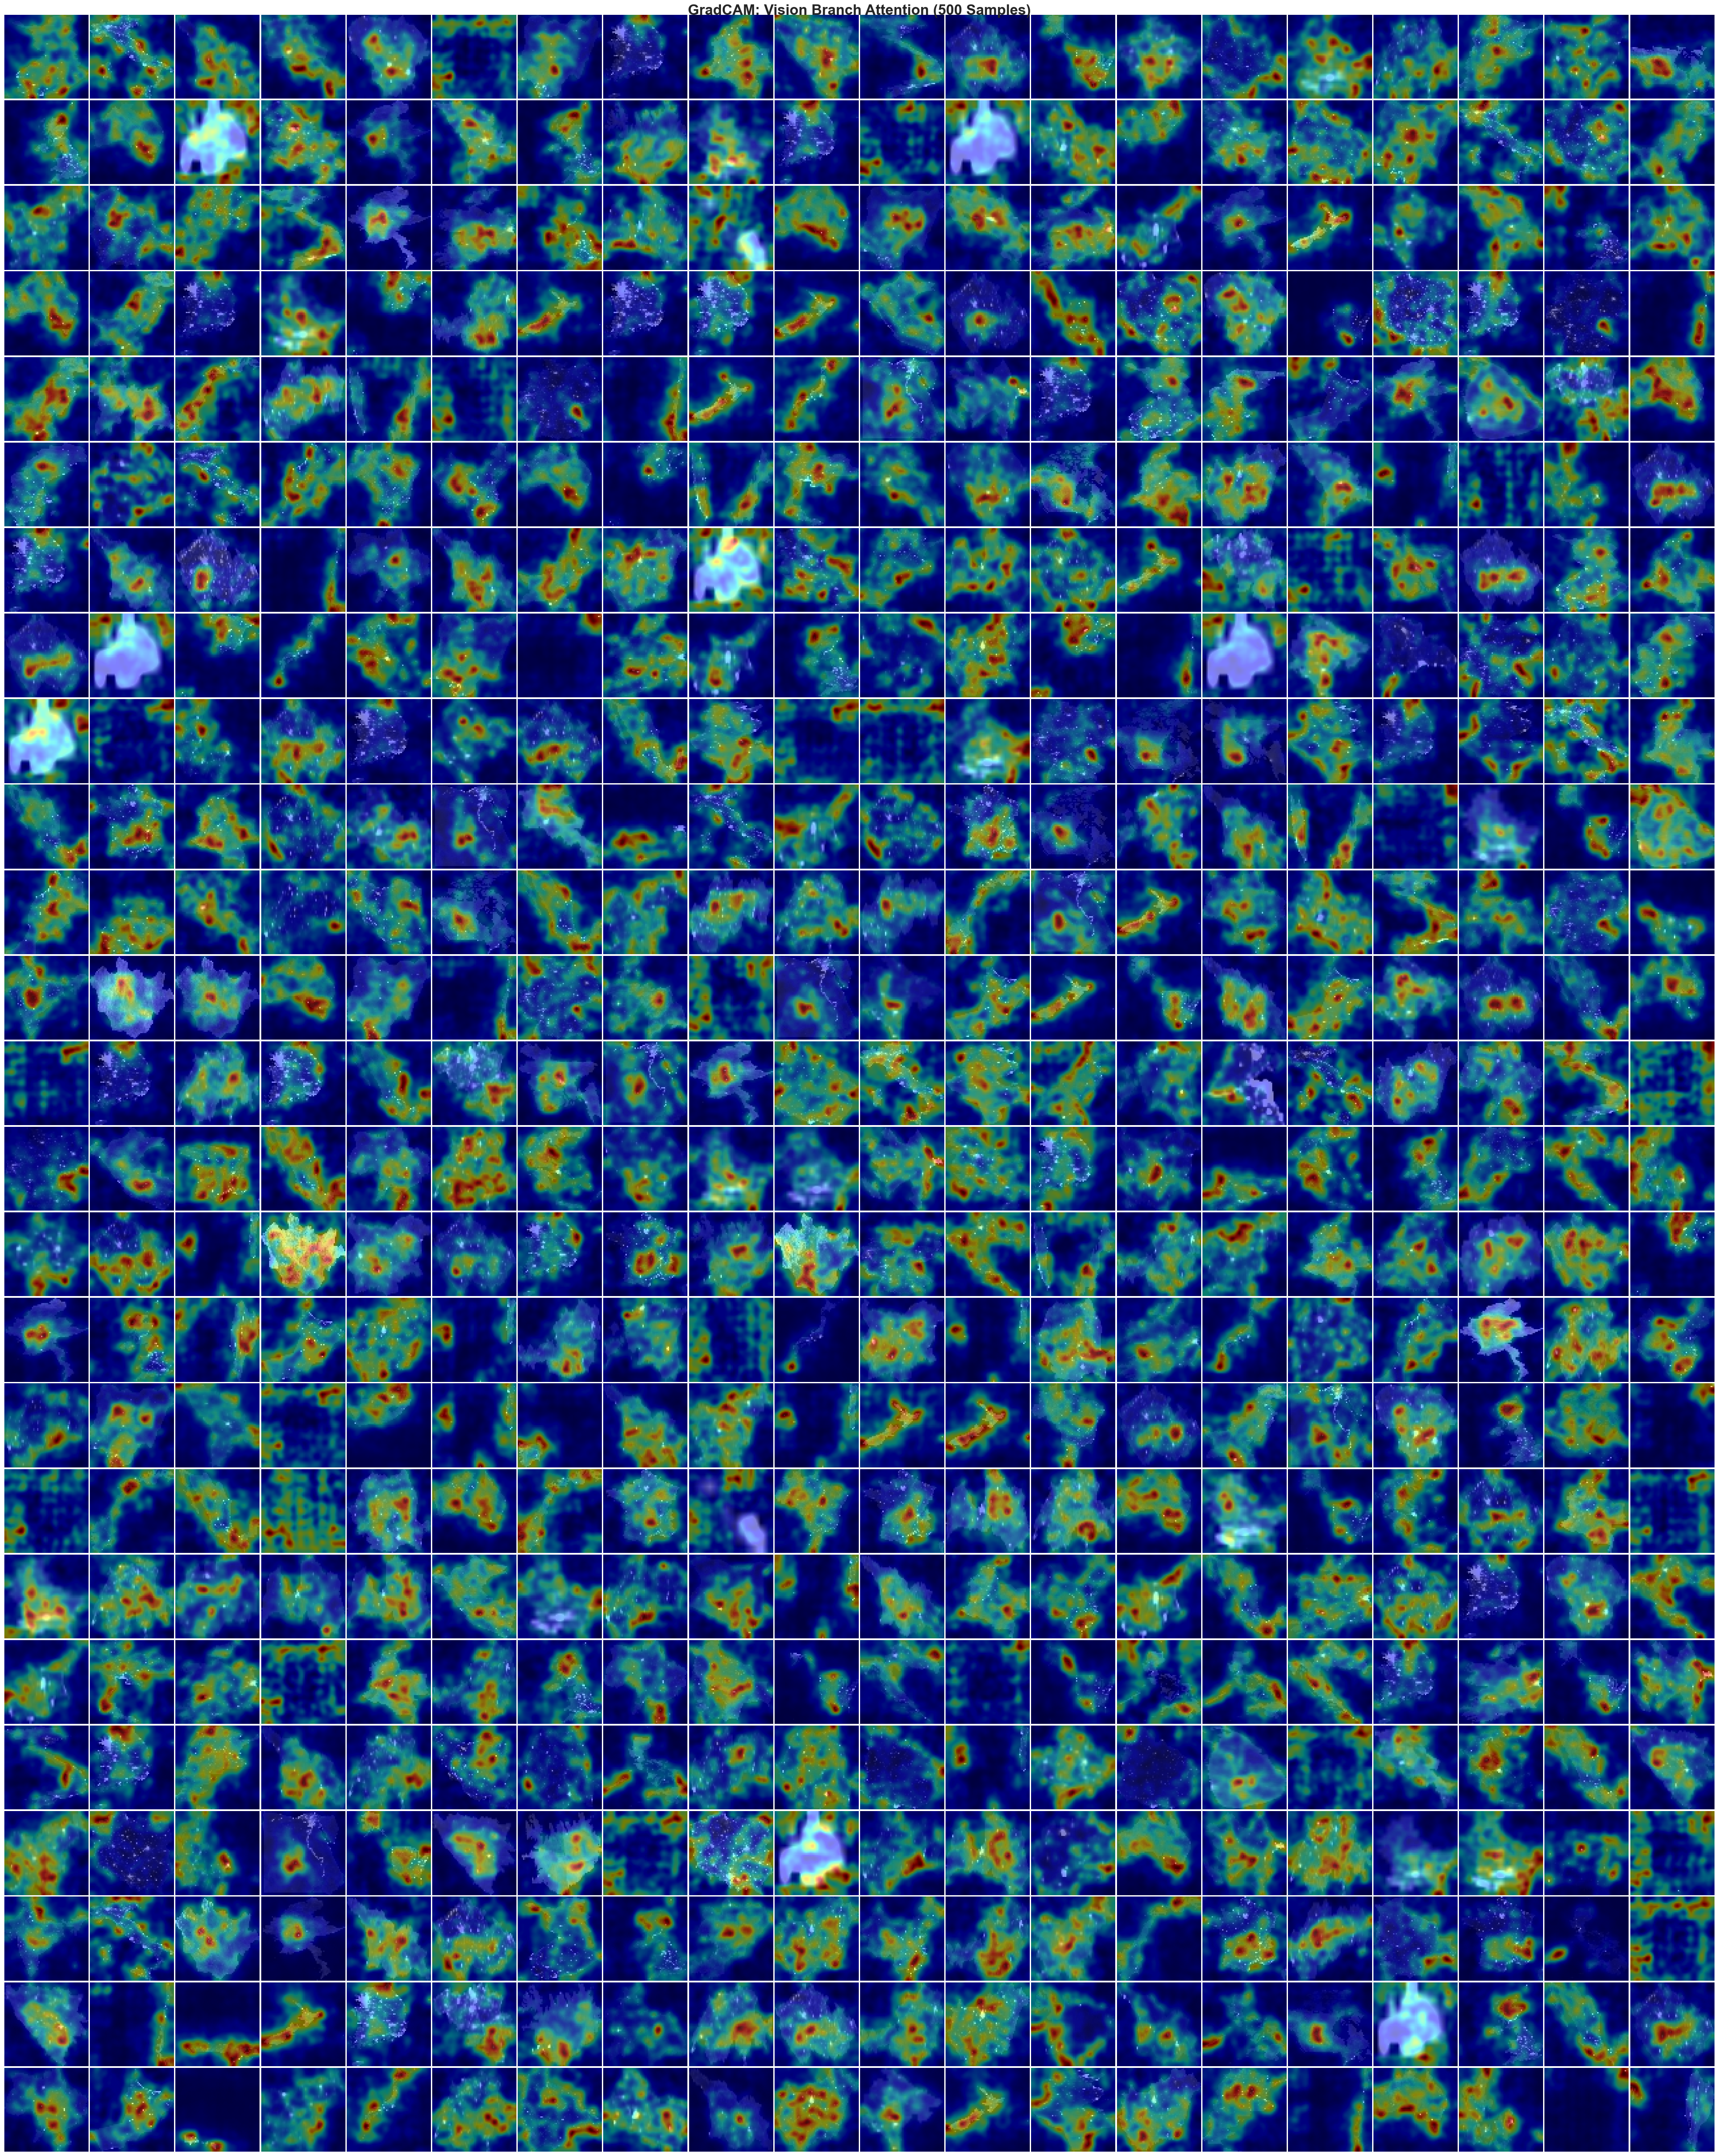


✅ GradCAM visualization complete for 500 samples
   Bright regions (red/yellow) = high importance for prediction
   Dark regions (blue/purple) = low importance


In [16]:
import cv2
import torch.nn.functional as F

def gradcam_swin(model, image, features):
    """
    Input Gradient-based Saliency for Swin Transformer
    Computes gradients directly on input pixels - avoids Swin's windowing artifacts
    """
    try:
        # Forward pass with gradient tracking on input
        model.train()  # Need gradients
        img = torch.FloatTensor(image[None]).requires_grad_(True)
        feat = torch.FloatTensor(features[None])
        
        # Forward through model
        output = model(img, feat)
        
        # Backward pass
        model.zero_grad()
        output.backward()
        
        # Get gradients on input image
        gradients = img.grad[0, 0]  # (H, W)
        
        # Use absolute gradients as importance (input saliency)
        saliency = torch.abs(gradients)
        
        # Smooth with Gaussian to reduce noise
        saliency_np = saliency.detach().cpu().numpy()
        saliency_np = cv2.GaussianBlur(saliency_np, (11, 11), 0)
        
        # Normalize
        saliency_np = (saliency_np - saliency_np.min()) / (saliency_np.max() - saliency_np.min() + 1e-8)
        
        return saliency_np
        
    finally:
        model.eval()  # Return to eval mode

# Visualize GradCAM for 500 samples
print("\n🔍 Generating GradCAM visualizations for 500 samples...\n")
print("   This may take a few minutes...\n")

num_samples = min(500, len(images))
rows, cols = 25, 20  # 25 rows × 20 cols = 500 samples

# Randomly select samples
sample_indices = np.random.choice(len(images), size=num_samples, replace=False)

fig, axes = plt.subplots(rows, cols, figsize=(40, 50))
fig.suptitle(f'GradCAM: Vision Branch Attention ({num_samples} Samples)', fontsize=24, fontweight='bold', y=0.995)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for i, idx in enumerate(sample_indices):
    if i % 50 == 0:
        print(f"   Processing sample {i+1}/{num_samples}...")
    
    image = images[idx]
    feat = features[idx]
    
    try:
        cam = gradcam_swin(model, image, feat)
        
        # Show GradCAM overlay directly
        axes_flat[i].imshow(image[0], cmap='gray')
        axes_flat[i].imshow(cam, cmap='jet', alpha=0.5)
        axes_flat[i].axis('off')
    except Exception as e:
        axes_flat[i].text(0.5, 0.5, 'X', ha='center', va='center', fontsize=8, color='red')
        axes_flat[i].axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.01, right=0.99, top=0.99, bottom=0.01)
plt.show()

print(f"\n✅ GradCAM visualization complete for {num_samples} samples")
print("   Bright regions (red/yellow) = high importance for prediction")
print("   Dark regions (blue/purple) = low importance")

## Country-wise Error Analysis

We will analyze the model's prediction errors grouped by country to identify any systematic biases or performance differences across regions.

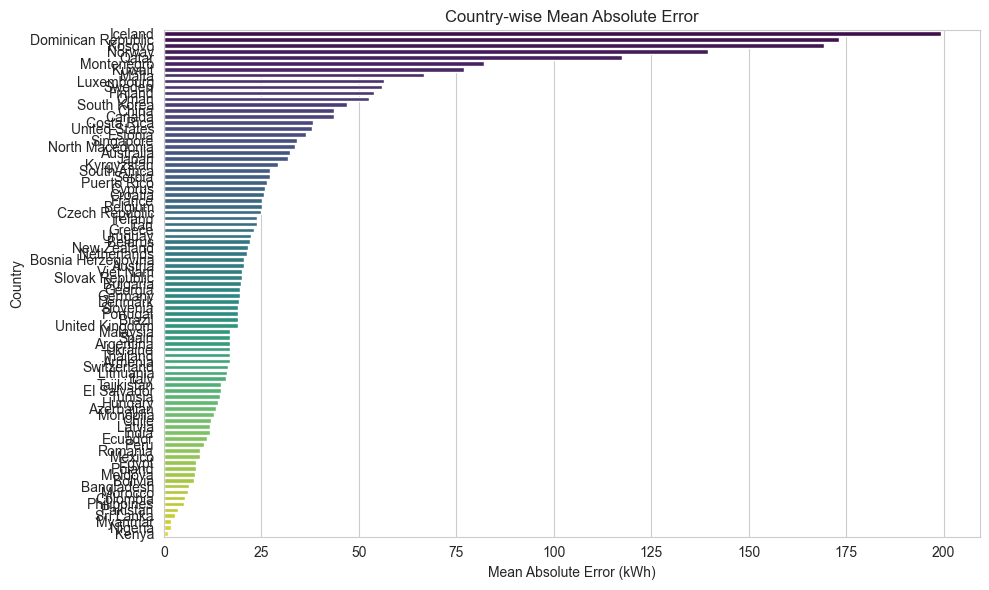

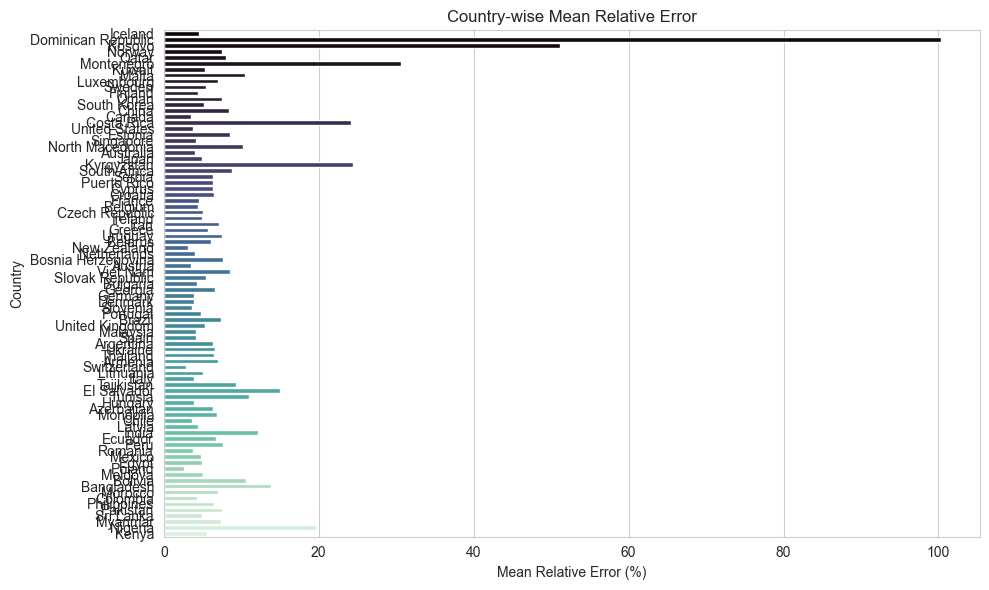

In [10]:
import pandas as pd

# Aggregate errors by country
df = pd.DataFrame({
    'country': countries,
    'year': years,
    'actual': actuals,
    'predicted': predictions,
    'abs_error': abs_errors,
    'rel_error': rel_errors
})
country_stats = df.groupby('country').agg({'abs_error': 'mean', 'rel_error': 'mean', 'actual': 'mean'}).sort_values('abs_error', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y=country_stats.index, x=country_stats['abs_error'], orient='h', palette='viridis')
plt.xlabel('Mean Absolute Error (kWh)')
plt.ylabel('Country')
plt.title('Country-wise Mean Absolute Error')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(y=country_stats.index, x=country_stats['rel_error'], orient='h', palette='mako')
plt.xlabel('Mean Relative Error (%)')
plt.ylabel('Country')
plt.title('Country-wise Mean Relative Error')
plt.tight_layout()
plt.show()

## Summary & Next Steps

- We performed prediction error analysis, permutation feature importance, SHAP analysis, GradCAM visualization, and country-wise error breakdown for the Swin+Tabular multimodal model.
- Use these insights to guide further model improvements, feature engineering, or targeted data collection for underperforming regions.

**Next steps:**
- Try more advanced XAI methods (e.g., Integrated Gradients, LIME).
- Investigate temporal or seasonal error patterns.
- Use XAI results to inform ablation or model refinement studies.